In [15]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
train_x1 = torch.linspace(0, 0.95, 50) + 0.05 * torch.rand(50)
train_x2 = torch.linspace(0, 0.95, 25) + 0.05 * torch.rand(25)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x2)

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module, mean_module):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



shared_kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

shared_likelihood = gpytorch.likelihoods.GaussianLikelihood()

model1 = ExactGPModel(train_x1, train_y1, shared_likelihood, shared_kernel)
model2 = ExactGPModel(train_x2, train_y2, shared_likelihood, shared_kernel)

#FROM TUTORIAL
# likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
# model1 = ExactGPModel(train_x1, train_y1, likelihood1)

# likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
# model2 = ExactGPModel(train_x2, train_y2, likelihood2)

In [18]:
model = gpytorch.models.IndependentModelList(model1, model2)
likelihood = gpytorch.likelihoods.LikelihoodList(shared_likelihood, shared_likelihood)

In [19]:
from gpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

In [ ]:


# -----------------------------
# Training
# -----------------------------
model.train()
likelihood.train()

optimizer = torch.optim.Adam(
    [
        {"params": model.parameters()},           ],
    lr=0.1,
)

print("=== Parameters seen by model.parameters() ===")
for name, p in model.named_parameters():
    print(name)

training_iterations = 50

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()

    if (i + 1) % 10 == 0:
        print(f"Iter {i+1}/{training_iterations} - Loss: {loss.item():.3f}")

# -----------------------------
# Parameter inspection
# -----------------------------
print("\n=== Parameter values per GP ===")

for i, m in enumerate(model.models):
    print(f"\nGP {i}")
    print("  lengthscale :", m.covar_module.base_kernel.lengthscale.item())
    print("  outputscale :", m.covar_module.outputscale.item())
    print("  noise       :", m.likelihood.noise.item())
    print("  mean        :", m.mean_module.constant.item())

# # Use the Adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# #todo, check noise is actually included
# for i in range(training_iterations):
#     optimizer.zero_grad()
#     output = model(*model.train_inputs)
#     loss = -mll(output, model.train_targets)
#     loss.backward()
#     print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
#     optimizer.step()



=== Parameters seen by model.parameters() ===
models.0.likelihood.noise_covar.raw_noise
models.0.mean_module.raw_constant
models.0.covar_module.raw_outputscale
models.0.covar_module.base_kernel.raw_lengthscale
models.1.mean_module.raw_constant
Iter 10/50 - Loss: 0.659
Iter 20/50 - Loss: 0.343
Iter 30/50 - Loss: 0.126
Iter 40/50 - Loss: 0.110
Iter 50/50 - Loss: 0.105

=== Parameter values per GP ===

GP 0
  lengthscale : 0.22410719096660614
  outputscale : 0.6512900590896606
  noise       : 0.03173219412565231
  mean        : -0.0025631794705986977

GP 1
  lengthscale : 0.22410719096660614
  outputscale : 0.6512900590896606
  noise       : 0.03173219412565231
  mean        : 0.3159029483795166


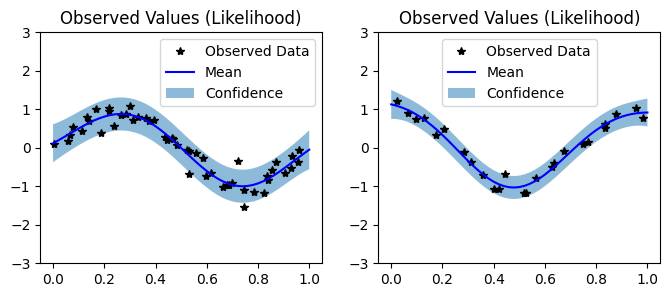

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))

for submodel, prediction, ax in zip(model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region()

    tr_x = submodel.train_inputs[0].detach().numpy()
    tr_y = submodel.train_targets.detach().numpy()

    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')

None